In [66]:
import pandas as pd
import torch
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler,OneHotEncoder
import numpy as np
from deepctr_torch.inputs import SparseFeat, DenseFeat, get_feature_names
from deepctr_torch.models import *
import torch.nn.functional as F

In [6]:
# data = pd.read_csv('./criteo_sample.txt')
data = pd.read_csv('./data/gbdt-lr/train.csv')
data.drop(['Id'], axis = 1, inplace = True)

sparse_features = ['C' + str(i) for i in range(1, 8)]
dense_features = ['I' + str(i) for i in range(1, 14)]

data[sparse_features] = data[sparse_features].fillna('-1', )
data[dense_features] = data[dense_features].fillna(0, )
target = ['label']

In [7]:
data

,Label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,1,1.0,0,1.0,0.0,227.0,1.0,173.0,18.0,50.0,...,3486227d,e88ffc9d,c393dc22,b1252a9d,57c90cd9,NaN,bcdee96c,4d19a3eb,cb079c2d,456c12a0
1,1,4.0,1,1.0,2.0,27.0,2.0,4.0,2.0,2.0,...,07c540c4,92555263,NaN,NaN,242bb710,NaN,3a171ecb,72c78f11,NaN,NaN
2,1,0.0,806,0.0,0.0,1752.0,142.0,2.0,0.0,50.0,...,07c540c4,25c88e42,21ddcdc9,b1252a9d,a0136dd2,NaN,32c7478e,8fc66e78,001f3601,f37f3967
3,0,2.0,-1,42.0,14.0,302.0,38.0,25.0,38.0,90.0,...,e5ba7672,5aed7436,21ddcdc9,b1252a9d,c3abeb21,NaN,423fab69,1793a828,e8b83407,5cef228f
4,1,0.0,57,2.0,1.0,2891.0,2.0,35.0,1.0,137.0,...,e5ba7672,642f2610,1d1eb838,b1252a9d,1640d50b,ad3062eb,423fab69,45ab94c8,2bf691b1,c84c4aec
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,0,0.0,8,1.0,1.0,43.0,0.0,0.0,1.0,1.0,...,1e88c74f,fc35e8fe,NaN,NaN,a02708ad,c9d4222a,c3dc6cef,502f2493,NaN,NaN
1595,0,8.0,2,20.0,8.0,36.0,9.0,8.0,10.0,8.0,...,e5ba7672,5aed7436,21ddcdc9,b1252a9d,eea796be,NaN,3a171ecb,1793a828,e8b83407,5cef228f
1596,0,0.0,1,2.0,12.0,4877.0,140.0,13.0,34.0,136.0,...,e5ba7672,2b0a9d11,NaN,NaN,7453e535,NaN,dbb486d7,906e72ec,NaN,NaN
1597,0,0.0,2,0.0,1.0,1972.0,0.0,0.0,1.0,14.0,...,e5ba7672,817481a8,NaN,NaN,e4244d7f,c9d4222a,c7dc6720,60efe6e6,NaN,NaN


In [8]:
# 类别变量的处理
for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat]=lbe.fit_transform(data[feat])

In [9]:
# 数值变量的处理
mms = MinMaxScaler(feature_range=(0, 1))
data[dense_features] = mms.fit_transform(data[dense_features])

In [10]:
data[sparse_features
    ].shape

(1599, 7)

In [247]:
pd.get_dummies(data[sparse_features[1]])

,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
196,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
197,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
198,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [11]:
df_sparse=pd.DataFrame()
for feat in sparse_features:
    df_feat=pd.get_dummies(data[feat])
    df_feat.columns=[feat+'_'+str(i) for i in range(1,df_feat.shape[1]+1)]
    df_sparse=pd.concat([df_sparse,df_feat],axis=1)

In [12]:
sparse_feature_num=df_sparse.shape[1]
df_data=pd.concat([df_sparse,data[dense_features]],axis=1)
del df_sparse
df_data.shape

(1599, 3247)

In [17]:
y=data['Label']

In [18]:
x_train, x_val, y_train, y_val = train_test_split(df_data, y, test_size = 0.3, random_state = 2018)

In [19]:
import torch
import torch.nn as nn
import torch.utils.data as Data 

In [20]:
val_dataset=Data.TensorDataset(torch.tensor(x_val.values),torch.tensor(y_val.values))
train_dataset=Data.TensorDataset(torch.tensor(x_train.values),torch.tensor(y_train.values))

In [21]:
BATCH_SIZE=25
val_loader=Data.DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)
train_loader=Data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

In [70]:
class ResBlock(nn.Module):
    def __init__(self,factor_num):
        super(ResBlock,self).__init__()
        self.factor_num=factor_num
        self.linear1=nn.Linear(factor_num,factor_num,bias=True)
        self.linear2=nn.Linear(factor_num,factor_num,bias=True)
        self.drop=nn.Dropout(p=0.5)
        
    def forward(self,x):
        out=self.linear1(x)
        out=self.drop(out)
        out=torch.relu(out)
        out=self.linear2(out)
        
        return torch.relu(out+x)

In [71]:
class DeepCrossing(nn.Module):
    def __init__(self,sparse_num,dense_num,layer_num,factor_num):
        super(DeepCrossing,self).__init__()
        self.sparse_num=sparse_num
        self.dense_num=dense_num
        self.layer_num=layer_num
        self.factor_num=factor_num
        
        self.v=nn.Parameter(torch.rand(self.sparse_num,self.factor_num))
        self.resblocks=nn.Sequential(
            *(layer_num*[ResBlock(factor_num=self.dense_num+self.factor_num)])
        )
        self.linear=nn.Linear(self.dense_num+self.factor_num,1)
        
    def forward(self,x):
        """
        tuple，第一维是稀疏特征，第二维是稠密特征
        """
        sparse_feature=x[0]
        dense_feature=x[1]
        
        embedding_feature=torch.matmul(sparse_feature,self.v)
        concat_feature=torch.cat((embedding_feature,dense_feature),1)
        
        out=self.resblocks(concat_feature)
        out=self.linear(out)
        out=torch.sigmoid(out)
        
        return out
    

In [93]:
next(model.resblocks[0].parameters()).requires_grad

True

In [82]:
dense_num=data[dense_features].shape[1]
loss_fn=nn.BCELoss()
model=DeepCrossing(sparse_num=sparse_feature_num,dense_num=dense_num,layer_num=2,factor_num=20)
optimizer=torch.optim.Adam(model.parameters(),lr=1e-3,weight_decay=1e-2)
# optimizer=torch.optim.SGD(model.parameters(),lr=1e-2,weight_decay=1e-3)


In [25]:
import datetime
from sklearn.metrics import accuracy_score

metric_func = lambda y_pred,y_true: accuracy_score(y_true.data.numpy(),y_pred.data.numpy()>0.5)
metric_name = "accuracy"


In [83]:
epochs = 100
log_step_freq = 30

dfhistory = pd.DataFrame(columns = ["epoch","loss",metric_name,"val_loss","val_"+metric_name]) 
print("Start Training...")
nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print("=========="*8 + "%s"%nowtime)

for epoch in range(epochs):
    model.train()
    loss_sum = 0.0
    metric_sum = 0.0
    step=1
    for step,(batch_x,batch_y) in enumerate(train_loader,1):
        batch_y=batch_y.float()
        batch_x=batch_x.float()
        input1=batch_x[:,:sparse_feature_num]
        input2=batch_x[:,sparse_feature_num:]
        input_all=[input1,input2]
        pred=model(input_all)
        loss=loss_fn(pred,batch_y)
        metric = metric_func(pred,batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
         # 打印batch级别日志
        loss_sum += loss.item()
        metric_sum += metric.item()

    model.eval()
    val_loss_sum = 0.0
    val_metric_sum = 0.0
    val_step=1

    for val_step,(val_x,val_y) in enumerate(val_loader,1):
        # 关闭梯度计算
        with torch.no_grad():
            val_y=val_y.float()
            val_x=val_x.float()
            input1=val_x[:,:sparse_feature_num]
            input2=val_x[:,sparse_feature_num:]
            input_all=[input1,input2]
            pred=model(input_all)
            val_loss=loss_fn(pred,val_y)
            val_metric = metric_func(pred,val_y)
            
        val_loss_sum += val_loss.item()
        val_metric_sum += val_metric.item()

    # 3，记录日志-------------------------------------------------
    info = (epoch, loss_sum/step, metric_sum/step, 
            val_loss_sum/val_step, val_metric_sum/val_step)
    dfhistory.loc[epoch-1] = info
    
    # 打印epoch级别日志
    print(("\nEPOCH = %d, loss = %.3f,"+ metric_name + \
          "  = %.3f, val_loss = %.3f, "+"val_"+ metric_name+" = %.3f") 
          %info)
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
        
print('Finished Training...')


Start Training...
================================================================================2020-08-31 16:53:09

EPOCH = 0, loss = 0.523,accuracy  = 0.807, val_loss = 0.579, val_accuracy = 0.744

================================================================================2020-08-31 16:53:09

EPOCH = 1, loss = 0.519,accuracy  = 0.809, val_loss = 0.576, val_accuracy = 0.744

================================================================================2020-08-31 16:53:10

EPOCH = 2, loss = 0.515,accuracy  = 0.809, val_loss = 0.578, val_accuracy = 0.744

================================================================================2020-08-31 16:53:10

EPOCH = 3, loss = 0.509,accuracy  = 0.808, val_loss = 0.577, val_accuracy = 0.744

================================================================================2020-08-31 16:53:10

EPOCH = 4, loss = 0.507,accuracy  = 0.809, val_loss = 0.573, val_accuracy = 0.744

==============================================================

================================================================================2020-08-31 16:53:25

EPOCH = 44, loss = 0.484,accuracy  = 0.809, val_loss = 0.564, val_accuracy = 0.744

================================================================================2020-08-31 16:53:25

EPOCH = 45, loss = 0.484,accuracy  = 0.809, val_loss = 0.565, val_accuracy = 0.744

================================================================================2020-08-31 16:53:25

EPOCH = 46, loss = 0.482,accuracy  = 0.809, val_loss = 0.564, val_accuracy = 0.744

================================================================================2020-08-31 16:53:26

EPOCH = 47, loss = 0.481,accuracy  = 0.809, val_loss = 0.565, val_accuracy = 0.744

================================================================================2020-08-31 16:53:26

EPOCH = 48, loss = 0.483,accuracy  = 0.809, val_loss = 0.564, val_accuracy = 0.744

===========================================================================

================================================================================2020-08-31 16:53:38

EPOCH = 88, loss = 0.470,accuracy  = 0.809, val_loss = 0.563, val_accuracy = 0.746

================================================================================2020-08-31 16:53:39

EPOCH = 89, loss = 0.468,accuracy  = 0.808, val_loss = 0.564, val_accuracy = 0.748

================================================================================2020-08-31 16:53:39

EPOCH = 90, loss = 0.468,accuracy  = 0.811, val_loss = 0.564, val_accuracy = 0.746

================================================================================2020-08-31 16:53:39

EPOCH = 91, loss = 0.467,accuracy  = 0.811, val_loss = 0.564, val_accuracy = 0.746

================================================================================2020-08-31 16:53:39

EPOCH = 92, loss = 0.464,accuracy  = 0.810, val_loss = 0.563, val_accuracy = 0.746

===========================================================================

In [74]:
dfhistory

,epoch,loss,accuracy,val_loss,val_accuracy
-1,0.0,0.544715,0.781099,0.597877,0.744
0,1.0,0.509973,0.808655,0.592475,0.744
1,2.0,0.502561,0.808655,0.585054,0.744
2,3.0,0.503113,0.808655,0.587868,0.744
3,4.0,0.495164,0.808655,0.581171,0.744
...,...,...,...,...,...
94,95.0,0.020308,0.994667,1.291138,0.764
95,96.0,0.021153,0.996444,1.260173,0.760
96,97.0,0.029948,0.994667,1.285168,0.760
97,98.0,0.025012,0.996444,1.230143,0.752


In [75]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

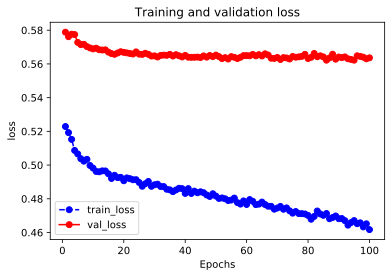

In [84]:
plot_metric(dfhistory,"loss")

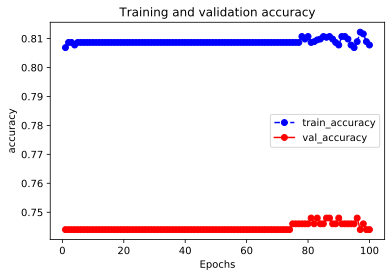

In [85]:
plot_metric(dfhistory,"accuracy")

In [242]:
y_train.sum(),y_train.shape

(label    31
 dtype: int64, (140, 1))

In [241]:
y_val.sum(),y_val.shape

(label    18
 dtype: int64, (60, 1))